#  (loss = :mrl, opt = :adagrad, agg = :max, constr = :nneg)

In [1]:
import json
import pprint
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

In [2]:
f = open('news.json', 'r')
data = f.readlines()[:1000000]

In [3]:
data = [json.loads(i) for i in data]

In [4]:
data = [{'title' : i['title'], 'descr' : i['descr']} for i in data]

In [5]:
news = pd.DataFrame(data)

In [6]:
news.head()

,descr,title
0,Следователи Скопинского МСО СУ СК РФ по Рязан...,В рязанской колонии заключенный ударил сотруд...
1,История Российской Федерации закончится распа...,«Работа такая…» Политолог о заявлениях на Укр...
2,"МОСКВА, 28 фев — РИА Новости. Госкорпорация «...",Роскосмос начал сбор анонимных жалоб на наруш...
3,"Вашингтон, 28 февраля /Синьхуа/ — Возвращение...",Срочно: Возвращение культурных ценностей в КН...
4,"МОСКВА, 28 февраля. /ТАСС/. Лекцию о знаменит...",Лекция о кондитерской династии Абрикосовых пр...


In [7]:
import re 
import nltk  
nltk.download('stopwords')  
import pickle  
from nltk.corpus import stopwords 
from nltk import PorterStemmer

import re 
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiapopova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(document):
    document = re.sub(r'\W', ' ',  document)
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    document = document.lower()
    document = document.split()
    document = [lemmatizer.lemmatize(word) for word in document]
    return ' '.join(document)

In [9]:
news.title = news.title.apply(lambda x: preprocess_text(x))
news.descr = news.descr.apply(lambda x: preprocess_text(x))
news.head()

,descr,title
0,следователи скопинского мсо су ск рф по рязанс...,в рязанской колонии заключенный ударил сотрудн...
1,история российской федерации закончится распад...,работа такая политолог о заявлениях на украине...
2,москва 28 фев риа новости госкорпорация роскос...,роскосмос начал сбор анонимных жалоб на наруше...
3,вашингтон 28 февраля синьхуа возвращение культ...,срочно возвращение культурных ценностей в кнр ...
4,москва 28 февраля тасс лекцию о знаменитой мос...,лекция о кондитерской династии абрикосовых про...


In [145]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X = vectorizer.fit_transform(news.descr)
y = vectorizer.transform(news.title)
features = vectorizer.get_feature_names()
word2num = {i:indx for indx, i in enumerate(features)} 
num2word = {indx:i for indx, i in enumerate(features)} 

In [148]:
X1, y1 = X, y

# def tokenize_(s):
    a = []
    for s_ in s.split(' '):
        try:
            a.append(word2num[s_])
        except:
            continue
    return a

In [235]:
X, y = X1, y1

In [236]:
#X = news.descr.apply(lambda x: tokenize_(x))
#y = news.title.apply(lambda x: tokenize_(x))
#X = X.astype(bool).astype(float)
#y = y.astype(bool).astype(float)

In [237]:
X.shape, y.shape

((1000000, 297567), (1000000, 297567))

In [307]:
def backward_hinge(u, v, v_hat, gamma=0.9):
    #print(type(u), type(v), type(v_hat))
    loss = gamma - np.dot(u, v.transpose()) + np.dot(u, v_hat.transpose()) #gamma - np.dot(u, v) + np.dot(u, v_hat)
    #print(type(u), type(v), type(v_hat))
    #print(loss)
    #return loss
    if loss > 0:
        #print('im here')
        return np.array(v_hat - v).flatten(), loss, -u, u
    return None, None, None, None

In [300]:
# https://codereview.stackexchange.com/questions/165371/implementing-adagrad-in-python
def adagrad_update_numpy(w, h, g_t, mask, lr=0.001, epsilon=1e-7):
    #print(g_t)
    h_new = h + g_t * g_t
    h_new = np.where(mask, h_new, h)
    w_new = w - lr * g_t / (np.sqrt(h_new) + epsilon)
    w_new = np.where(mask, w_new, w)
    return w_new, h_new


def update(embedding, idx, max_indicies, delta, nu):
    p = emb.data[:, idx][:, max_indicies]
    print(p)
    g = emp.sigma[:, idx][:, max_indicies]
    emb.sigma[:, idx][:, max_indicies] += delta**2
    emp.data[:, idx][:, max_indicies] -= delta * nu / (np.sqrt(g) + eps)

In [301]:
a = np.array([1, 2,3])
a * a

array([1, 4, 9])

In [302]:
def agg(w, x):
    EPS = 1e-8
    #print(type(w), type(x))
    try:
        x = x.todense()
    except:
        pass
    w_filtered_by_words = np.multiply(w, x.transpose()) # .todense() тут выбрали веса по тем словам, которые есть
    res = w_filtered_by_words.max(axis=0) # посчитали эмбэдинг
    # взяли веса, которые равны эмбэдингу и занулили случайные совпадения левых слов
    mask = np.multiply((abs(np.vstack([res for _ in range(w.shape[0])]) - w) < EPS), (w_filtered_by_words > 0.))
    #print(mask.shape)
    #print(type(w), type(x))
    return res, mask # mask show values to update

def get_element(w, X, i):
    return agg(w, X[i]), agg(w, y[i]), agg(w, X[np.random.randint(0, X.shape[0])])

In [314]:
n_embed = 10
weights = np.random.normal(0., 1., size = (X.shape[1], n_embed))
grad = np.zeros_like(weights)

In [244]:
agg(weights, X[0])[0].shape, agg(weights, X[0])[1].shape # эмбэдинг и маска

<class 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'> <class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.ndarray'> <class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'> <class 'numpy.matrixlib.defmatrix.matrix'>


((1, 10), (297567, 10))

In [ ]:
def recall_at_k(y_pred, k):
    """
    Calculates recall at k ranking metric.
    Args:
        y_predicted: Predictions.
            Each prediction contains ranking score of all ranking candidates for the particular data sample.
            It is supposed that the ranking score for the true candidate goes first in the prediction.
    Returns:
        Recall at k
    """
    num_examples = float(len(y_pred))
    predictions = np.array(y_pred)
    predictions = np.flip(np.argsort(predictions, -1), -1)[:, :k]
    num_correct = 0
    for el in predictions:
        if 0 in el:
            num_correct += 1
    return float(num_correct) / num_examples



In [351]:
from sklearn.metrics.pairwise import cosine_similarity
import heapq

def evaluate(w, x, k=2, num_examples=10): # капееееец долго
    num_correct = 0
    ys = np.array([agg(w, i)[0] for i in x[:5]]).reshape((5, n_embed))
    for _ in range(10):
        indx = np.random.randint(0, x.shape[0])
        pred, mask = agg(w, x[indx])
        #print(ys.shape, pred.shape)
        distances = cosine_similarity(ys, pred)
        #print(distances.shape)
        neig_t = [i[0] for i in heapq.nlargest(k, enumerate(distances), key=lambda x: x[1])] # вроде, тут индексы топ к
        #print(neig_t)
        if indx in  neig_t:
            num_correct += 1
    return float(num_correct) / num_examples

In [ ]:
evaluate(weights, X)

In [315]:
n_epoch = 5
gamma = 0.9
training_loss = []
training_acc = []
for epoch in range(n_epoch):
    epoch_loss=[]
    for indx in range(X.shape[0]):
        #print(1)
        #true, y, wrong = get_element(weights.copy(), X.copy(), indx) # не знаю, что за магия, но тут портятся типы
        x_true, mask_true = agg(weights, X[indx]) #true
        y_true, y_mask = agg(weights, y[indx]) # y
        x_wrong, mask_wrong = agg(weights, X[np.random.randint(0, X.shape[0])]) #wrong
        #print(x_true.shape, mask_true.shape)
        #print(y_true.shape)
        #print(x_wrong.shape, mask_wrong.shape)
        #print('-----------------------')
        delta, loss_, _u, u = backward_hinge(y_true, x_true, x_wrong, gamma) # что-то я не поняла, что мы с этим лоссом делаем
        # надо как-то обработать для лосс=0
        if delta is not None:
            weights, grad = adagrad_update_numpy(weights, grad, delta, mask_true, lr=0.001, epsilon=1e-7)
            epoch_loss.append(loss_)
        training_loss.append(np.mean(epoch_loss))

KeyboardInterrupt: 

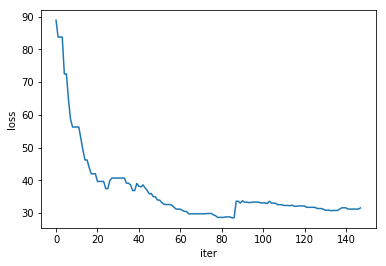

In [323]:
from matplotlib import pyplot as plt

plt.plot(training_loss)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

# Network

In [101]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):        
        pass

    def updateGradInput(self, input, gradOutput):
        pass   
    
    def accGradParameters(self, input, gradOutput):
        pass
    
    def zeroGradParameters(self): 
        pass
        
    def getParameters(self):
        return []
        
    def getGradParameters(self):
        return []
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __repr__(self):
        return "Module"

class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        self.output = [input]
        for module in self.modules:
            self.output.append(module.forward(self.output[-1]))
        return self.output[-1]
        #return self.output

    def backward(self, input, gradOutput):
        self.gradInput =  gradOutput   
        for i, module in enumerate(reversed(self.modules)):
            self.gradInput = module.backward(self.output[-i-2], self.gradInput)
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()
            
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.output = #input @ self.W.T + self.b
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = gradOutput.T @ input
        self.gradb = np.sum(gradOutput, axis = 0)
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

# Criterion

In [75]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput   

    def __repr__(self):
        return "Criterion"
    
# class ClassNLLCriterionUnstable(Criterion):
#     EPS = 1e-15
#     def __init__(self):
#         a = super(ClassNLLCriterionUnstable, self)
#         super(ClassNLLCriterionUnstable, self).__init__()
        
#     def updateOutput(self, input, target):         
#         input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
#         self.output = -1/input.shape[0] * np.sum(target * np.log(input_clamp))
#         return self.output

#     def updateGradInput(self, input, target):
#         input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
#         self.gradInput = -target/(input.shape[0] * input_clamp)
#         return self.gradInput
    
#     def __repr__(self):
#         return "ClassNLLCriterionUnstable"
    
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        self.output = -1/input.shape[0] * np.sum(target * input)
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target/input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

## [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer
- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
- `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)

Formulas for optimizer:

Current step learning rate: $$\text{lr}_t = \text{learning_rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$ 
Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$

In [71]:
def adam_optimizer(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))

            np.add(var_first_moment * config['beta1'], (1 - config['beta1']) * current_grad, out=var_first_moment)
            np.add(var_second_moment * config['beta2'], (1 - config['beta2']) * current_grad * current_grad, out=var_second_moment)
            current_var -= lr_t * var_first_moment / (np.sqrt(var_second_moment) + config['epsilon'])
                        
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1


In [ ]:
len_ = 3 # n layers

weights = Sequential()
for i in range(len_):
    weights.add(Linear(n_in=len(features), n_out=len(features)))
#net.add(BatchNormalization(alpha=0.5))
#net.add(ChannelwiseScaling(n_out=50))
#net.add(ReLU())
#net.add(Linear(n_in=50, n_out=10))
#net.add(LogSoftMax())

#weights = Linear(len(features), len_)

In [ ]:
n_epoch = 10

for epoch in range(n_epoch):
    weights.zeroGradParameters()
    
    # те какие-то манипуляции с текстами
    indx = np.random.randint(0, X.shape[0])
    x_true, y_true, x_wrong = get_element(weights.getParameters()[0], indx):
        
    #loss = criterion(input1, input2, target)
    
    #weights.backward(x_batch, criterion.backward(y_pred, y_batch))
    
    adam_optimizer(weights.getParameters(), 
                     weights.getGradParameters(), 
                     config = {'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-9},
                     state = {})   
    
    # assert контролируем nneg

In [ ]:
#  -----------------------------------------------------------------------------------------------

In [ ]:
def train():
    weights.train()
    train_acc_ = 0.
    loss_train_ = 0.
    if i == 30:
        lr /= 10.
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        weights.zeroGradParameters()
        y_pred = weights.forward(x_batch)
        loss = criterion.forward(y_pred, y_batch)
        train_acc += accuracy(y_pred, y_batch)
        loss_train += loss       
        weights.backward(x_batch, criterion.backward(y_pred, y_batch))
        adam_optimizer(weights.getParameters(), 
                     weights.getGradParameters(), 
                     config = {'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-9},
                     state = {})   
    acc_train_ /= len(y_train) / batch_size
    return train_acc_, loss_train_

In [67]:
import torch
from torch.nn.modules.loss import MarginRankingLoss
from torch.optim import Adagrad

weights = [torch.tensor(i).float() for i in weights]
sgd_learning_rate = 0.1
momentum = 0.9

criterization = MarginRankingLoss()
optimizer =  Adagrad(weights, sgd_learning_rate)

In [69]:
def adagrad_update_numpy(param, accum, g_t, lr=0.001, epsilon=1e-7):
      accum_t = accum + g_t * g_t
      param_t = param - lr * g_t / (np.sqrt(accum_t) + epsilon)
      return param_t, accum_t
    
def sparse_adagrad_update_numpy(param,
                                accum,
                                gindexs,
                                gvalues,
                                lr=0.001,
                                epsilon=1e-7):
      accum_t = copy.deepcopy(accum)
      param_t = copy.deepcopy(param)
      # first loop accumulates repeated indices if necessary.
      for i in range(len(gindexs)):
        gindex = gindexs[i]
        gvalue = gvalues[i]
        accum_t[gindex] = accum_t[gindex] + gvalue * gvalue
      for i in range(len(gindexs)):
        gindex = gindexs[i]
        gvalue = gvalues[i]
        param_t[gindex] = param_t[gindex] - lr * gvalue / (
            np.sqrt(accum_t[gindex]) + epsilon)
      return param_t, accum_t

In [ ]:
n_epoch = 10

for epoch in range(n_epoch):
    optimizer.zero_grad()
    
    # те какие-то манипуляции с текстами
    
    loss = criterization(input1, input2, target)
    
    loss.backward()
    optimizer.step()
    
    # assert l2 == 1 and l2 < числа

In [58]:
from torch.nn import Module

from torch import functional as F
from torch import _reduction as _Reduction
from torch._jit_internal import weak_module, weak_script_method

def margin_ranking_loss(input1, input2, target, margin=0, size_average=None,
                        reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Tensor, float, Optional[bool], Optional[bool], str) -> Tensor
    r"""margin_ranking_loss(input1, input2, target, margin=0, size_average=None, reduce=None, reduction='mean') -> Tensor
    See :class:`~torch.nn.MarginRankingLoss` for details.
    """  # noqa
    if size_average is not None or reduce is not None:
        reduction_enum = _Reduction.legacy_get_enum(size_average, reduce)
    else:
        reduction_enum = _Reduction.get_enum(reduction)
    if input1.dim() == 0 or input2.dim() == 0 or target.dim() == 0:
        raise RuntimeError(("margin_ranking_loss does not support scalars, got sizes: "
                            "input1: {}, input2: {}, target: {} ".format(input1.size(), input2.size(), target.size())))
    return torch.margin_ranking_loss(input1, input2, target, margin, reduction_enum)

class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction
            
class MarginRankingLoss(_Loss):
    __constants__ = ['margin', 'reduction']

    def __init__(self, margin=0., size_average=None, reduce=None, reduction='mean'):
        super(MarginRankingLoss, self).__init__(size_average, reduce, reduction)
        self.margin = margin

    @weak_script_method
    def forward(self, input1, input2, target):
        return F.margin_ranking_loss(input1, input2, target, margin=self.margin, reduction=self.reduction)

ImportError: cannot import name '_reduction'

In [59]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)


class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # update the momentum
                p.state_dict["momentum"] *= self.momentum
                p.state_dict["momentum"] -= self.lr * p.grad
                # update the parameter
                p.data += p.state_dict["momentum"]
            else:
                p.data -= self.lr * p.grad

NameError: name 'Iterable' is not defined